In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker22
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from palettable.colorbrewer.sequential import PuBuGn_9
from palettable.colorbrewer.qualitative import Pastel1_4
from xarrayMannKendall import *

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '../results/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:43549 Dashboard: /proxy/36319/status,Cluster Workers: 6 Cores: 24 Memory: 96.00 GiB


In [2]:
def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    else:
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

# Loading datasets

In [3]:
uas_hist = {}
vas_hist = {}
uas_proj = {}
vas_proj = {}
# CMIP6 multimodel mean
uas_hist['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc').isel(time = slice(-120, None))
vas_hist['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc').isel(time = slice(-120, None))
uas_proj['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-2015_2100-ssp85.nc').isel(time = slice(-120, None))
vas_proj['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-2015_2100-ssp85.nc').isel(time = slice(-120, None))

# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_hist[model_name] = xr.open_dataset(path_uas[i]).isel(time = slice(-120, None))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_hist[model_name] = xr.open_dataset(path_vas[i]).isel(time = slice(-120, None))

path_uas = glob.glob('../data/cmip6-regridded/uas_ssp*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas_proj[model_name] = xr.open_dataset(path_uas[i]).isel(time = slice(-120, None))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas_proj[model_name] = xr.open_dataset(path_vas[i]).isel(time = slice(-120, None))
model_names = list(uas_hist.keys())

In [4]:
shelf_mask = xr.open_dataset('../data/shelf_mask_1500misobath.nc')['__xarray_dataarray_variable__']
shelf_mask = change_lon_space(shelf_mask, 'u')

In [5]:
uas_eoc = {}
vas_eoc = {}
for n in model_names:
    uas_eoc[n] = uas_proj[n]['uas'].mean('time') - uas_hist[n]['uas'].mean('time')
    vas_eoc[n] = vas_proj[n]['vas'].mean('time') - vas_hist[n]['vas'].mean('time')

In [6]:
uas_finer = uas_eoc['CMIP6'].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
vas_finer = vas_eoc['CMIP6'].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
ws_finer = np.sqrt(uas_finer**2 + vas_finer**2)

In [7]:
uas_vec = uas_proj['CMIP6']['uas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
vas_vec = vas_proj['CMIP6']['vas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
ws_vec = np.sqrt(uas_vec**2 + vas_vec**2)

In [8]:
uas_std = uas_eoc[model_names[1]]
vas_std = vas_eoc[model_names[1]]
for n in model_names[2:]:
    uas_std = xr.concat([uas_std, uas_eoc[n]], dim = 'model')
    vas_std = xr.concat([vas_std, vas_eoc[n]], dim = 'model')

In [9]:
uas_std = uas_std.std(dim = 'model').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
vas_std = vas_std.std(dim = 'model').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])

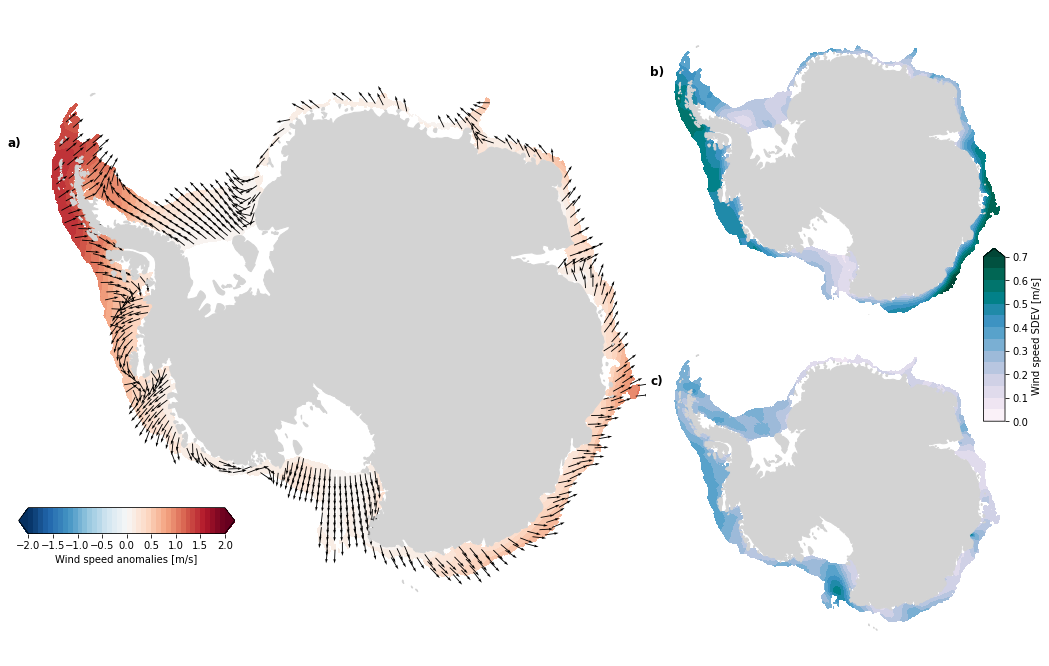

In [20]:
fig, axs = southern_ocean_plot_2()
# ERA Interim
c = axs[0].contourf(uas_finer['lon'], uas_finer['lat'], ws_finer*shelf_mask, 
                    levels = np.arange(-2, 2.1, .1), extend = 'both', cmap = 'RdBu_r', transform = ccrs.PlateCarree())
fig.colorbar(c, cax = fig.add_axes([0.12, 0.27, 0.15, 0.03]) , orientation = 'horizontal').set_label('Wind speed anomalies [m/s]')
axs[0].quiver(uas_vec['lon'].values[::20], uas_vec['lat'].values[::15], 
             (uas_vec*shelf_mask/ws_vec).values[::15,::20], (vas_vec*shelf_mask/ws_vec).values[::15,::20],
              scale = 45, width = 1.4e-3, transform = ccrs.PlateCarree())
axs[1].contourf(uas_std['lon'], uas_std['lat'], uas_std*shelf_mask, 
                levels = np.arange(0, .75, .05), extend = 'max', cmap = PuBuGn_9.mpl_colormap, transform = ccrs.PlateCarree())
c = axs[2].contourf(vas_std['lon'], vas_std['lat'], vas_std*shelf_mask, 
                    levels = np.arange(0, .75, .05), extend = 'max', cmap = PuBuGn_9.mpl_colormap, transform = ccrs.PlateCarree())
fig.colorbar(c, cax = fig.add_axes([0.79, 0.4, 0.015, 0.2]) , orientation = 'vertical').set_label('Wind speed SDEV [m/s]')

plt.savefig('../results/fig4.png', facecolor = 'white', bbox_inches = 'tight')

In [11]:
ws = {}
for n in model_names:
    ws[n] = np.sqrt(uas_proj[n]['uas'].mean('time')**2 + vas_proj[n]['vas'].mean('time')**2)

In [12]:
ws_hist = {}
for n in model_names:
    ws_hist[n] = np.sqrt(uas_hist[n]['uas'].mean('time')**2 + vas_hist[n]['vas'].mean('time')**2)

In [13]:
# mask peninsula to avoid anomalies there:
peninsula_mask = ws['CMIP6'].where(ws['CMIP6']['lat']<-68).where(ws['CMIP6']['lon']>-70).where(ws['CMIP6']['lon']<-64)*0
peninsula_mask = peninsula_mask.fillna(1)
peninsula_mask = peninsula_mask.where(peninsula_mask==1)

latitude = ws['CMIP6']['lat']
longitude = ws['CMIP6']['lon']

def find_min_lat(var):
    # mask outside of 60 and 80S:
    speed_mask = var.where(var['lat']<-60).where(var['lat']>-80)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim = 'lat')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > 4:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(lon=3,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(lat=smoothed_min_lat_indices.astype(int))
    lat_xarray = xr.DataArray(smoothed_min_lat, dims = {'lon'}, coords = {'lon':longitude})
    lat_xarray = xr.where((lat_xarray['lon'] < -64) & (lat_xarray['lon'] > -70), np.nan, lat_xarray)
    
    return lat_xarray

In [14]:
zero_wind_lat = {}
for n in model_names:
    zero_wind_lat[n] = find_min_lat(ws[n])

zero_wind_std = zero_wind_lat[model_names[1]]
for n in model_names[2:]:
    zero_wind_std = xr.concat([zero_wind_std, zero_wind_lat[n]], dim = 'model')
zero_wind_std = zero_wind_std.std('model')

In [15]:
zero_wind_lat_hist = {}
for n in model_names:
    zero_wind_lat_hist[n] = find_min_lat(ws_hist[n])

zero_wind_std_hist = zero_wind_lat_hist[model_names[1]]
for n in model_names[2:]:
    zero_wind_std_hist = xr.concat([zero_wind_std_hist, zero_wind_lat_hist[n]], dim = 'model')
zero_wind_std_hist = zero_wind_std_hist.std('model')

In [18]:
def southern_ocean_plot_2():
    fig = plt.figure(figsize = (20, 12))
    gr = gs.GridSpec(2, 2, figure = fig, wspace = -0.1, hspace = -0.1); 
    axs = [fig.add_subplot(gr[:,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)', 'c)']):
        ax.set_extent([-180, 180, -90, -62], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'))
        ax.spines['geo'].set_edgecolor(None)
        ax.text(-0.03, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
        ax.patch.set_alpha(0)
    return fig, axs

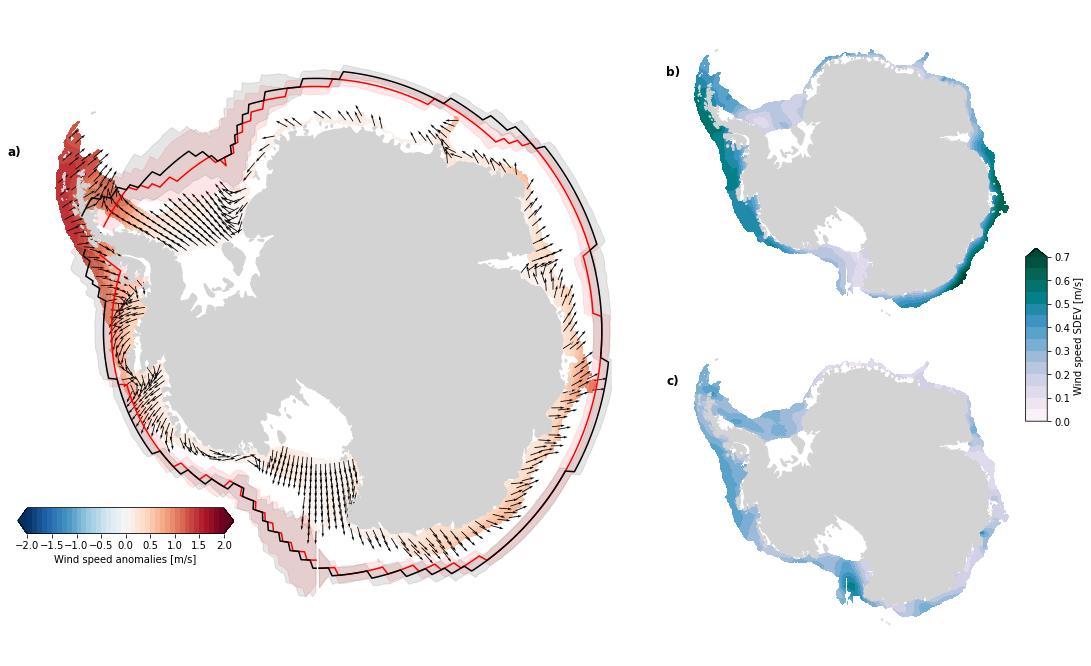

In [19]:
fig, axs = southern_ocean_plot_2()
# ERA Interim
c = axs[0].contourf(uas_finer['lon'], uas_finer['lat'], ws_finer*shelf_mask, 
                    levels = np.arange(-2, 2.1, .1), extend = 'both', cmap = 'RdBu_r', transform = ccrs.PlateCarree())
fig.colorbar(c, cax = fig.add_axes([0.12, 0.27, 0.15, 0.03]) , orientation = 'horizontal').set_label('Wind speed anomalies [m/s]')
axs[0].quiver(uas_vec['lon'].values[::20], uas_vec['lat'].values[::15], 
             (uas_vec*shelf_mask/ws_vec).values[::15,::20], (vas_vec*shelf_mask/ws_vec).values[::15,::20],
              scale = 45, width = 1.4e-3, transform = ccrs.PlateCarree())
axs[0].plot(zero_wind_lat['CMIP6']['lon'], zero_wind_lat['CMIP6'], color = 'r', transform = ccrs.PlateCarree())
axs[0].fill_between(zero_wind_lat['CMIP6']['lon'], zero_wind_lat['CMIP6']-zero_wind_std, zero_wind_lat['CMIP6']+zero_wind_std, 
                    color = 'r', alpha = 0.1, transform = ccrs.PlateCarree())
axs[0].plot(zero_wind_lat_hist['CMIP6']['lon'], zero_wind_lat_hist['CMIP6'], color = 'k', transform = ccrs.PlateCarree())
axs[0].fill_between(zero_wind_lat_hist['CMIP6']['lon'], zero_wind_lat_hist['CMIP6']-zero_wind_std_hist, zero_wind_lat_hist['CMIP6']+zero_wind_std_hist, 
                    color = 'k', alpha = 0.1, transform = ccrs.PlateCarree())

axs[1].contourf(uas_std['lon'], uas_std['lat'], uas_std*shelf_mask, 
                levels = np.arange(0, .75, .05), extend = 'max', cmap = PuBuGn_9.mpl_colormap, transform = ccrs.PlateCarree())
c = axs[2].contourf(vas_std['lon'], vas_std['lat'], vas_std*shelf_mask, 
                    levels = np.arange(0, .75, .05), extend = 'max', cmap = PuBuGn_9.mpl_colormap, transform = ccrs.PlateCarree())

fig.colorbar(c, cax = fig.add_axes([0.82, 0.4, 0.015, 0.2]) , orientation = 'vertical').set_label('Wind speed SDEV [m/s]')
plt.savefig('../results/fig4.png', facecolor = 'white', bbox_inches = 'tight')